In [319]:
import time,json,os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.ensemble import BaggingClassifier
from common import preprocess
import seaborn as sns
from sklearn.svm import SVC
import joblib
from warnings import filterwarnings
filterwarnings("ignore") 
np.set_printoptions(suppress=True)
pd.set_option('display.float_format',lambda x : '%.8f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.style.use({'figure.figsize':(12, 4)})

In [320]:
def show_heatmap(df):
    plt.style.use({'figure.figsize':(16, 6)})
    plt.ticklabel_format(style='plain',axis='both')
    cmap = sns.cubehelix_palette(start = 1, rot = 3, gamma=0.8, as_cmap = True)
    return sns.heatmap(df, cmap = cmap, linewidths = 0.05,annot=False, fmt="g",annot_kws={"fontsize":16})
    #plt.xticks(rotation=60)
    #plt.yticks(rotation=60)

In [321]:
class CJAnalyse:
    
    def __init__(self, model_name):
        self.df_similarity = pd.read_csv("/data/paper/analyse/similarity.csv",index_col=0)
        self.df_model = pd.read_csv("/data/paper/analyse/%s.csv"%model_name,index_col=0)
        self.filter_useless_fields()
        
    def get_similar(self, d1, d2):
        mask = (self.df_similarity['D1'] == "%s"%d1) & (self.df_similarity['D2'] == d2)
        ret = {}
        for D in self.df_similarity.keys():
            if D in ['D1','D2']:
                continue
            ret[D] = self.df_similarity[mask].iloc[0][D]
        return ret
    
    def filter_useless_fields(self):
        df_m = self.df_model.copy( deep = True )
        del df_m['confusion_matrix']
        del df_m['roc_curve']
        del df_m['mcc']
        del df_m['log_loss']
        del df_m['fbeta_score']
        self.df_model = df_m
        
    def Merge(self):
        all_data = []
        for item in json.loads(self.df_model.to_json(orient="records")):
            tmp = item
            tmp["train"] = item["train"]
            tmp["valid"] = item["valid"]
            similar = self.get_similar(item["train"], item['valid'])
            for s in similar:
                tmp[s] = similar[s]
            all_data.append(tmp)
        return pd.DataFrame(all_data)
    
    #pearsonr,spearmanr or kendalltau
    def Correlation(self,df, kind = "pearsonr"):
        df_merged = df.copy( deep= True )
        all_data = []
        for score in self.df_model.keys():
            if score in ['model', 'train', 'valid']:
                continue
            s1 = df_merged[score]
            metric_value = {}
            metric_value['score'] = score
            metric_list = self.df_similarity.keys()
            for metric in metric_list:
                if metric in ['D1','D2']:
                    continue
                s2 = df_merged[metric]
                if kind == 'pearsonr':
                    metric_value[metric] = scipy.stats.pearsonr(s1,s2)[0]
                if kind == 'spearmanr':
                    metric_value[metric] = scipy.stats.spearmanr(s1,s2)[0]
                if kind == 'kendalltau':
                    metric_value[metric] = scipy.stats.kendalltau(s1,s2)[0]
                metric_value[metric] = abs(metric_value[metric])
            all_data.append(metric_value)

        df_all = pd.DataFrame(all_data)
        df_all.set_index("score", inplace = True, drop = True)
        return df_all #.reset_index()

In [322]:
test = CJAnalyse("deeplearn")
df_all = test.Merge()

# Correlations for each base set

In [323]:
df_base_set_corr = pd.DataFrame()
for train_set in ["s-0-*","s-1-*","s-2-*","s-3-*"]:
    mask = df_all.train.str.contains(r'%s'%train_set)
    df_test = df_all[mask]
    df_base_set_corr[train_set] = test.Correlation(df_test).mean()
display(df_base_set_corr.T.mean())
df_base_set_corr.T

Cosine      0.63133347
Pearson     0.63133426
Euclidean   0.65897223
EDM         0.76032305
KS          0.53416634
Manhattan   0.71367788
Minkowski   0.63676378
Jaccard     0.16537144
dtype: float64

,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
s-0-*,0.58351256,0.58337928,0.68386307,0.79162545,0.70323946,0.66090533,0.71360529,0.17561346
s-1-*,0.58777189,0.58772495,0.58728803,0.60865172,0.33157872,0.57925678,0.55999263,0.20580903
s-2-*,0.70564506,0.70574648,0.69924184,0.86240690,0.53337886,0.84547356,0.64404288,0.13867282
s-3-*,0.64840438,0.64848632,0.66549600,0.77860812,0.56846832,0.76907584,0.62941430,0.14139044


Text(0.5, 1.0, 'Correlation between Base sample and Distance')

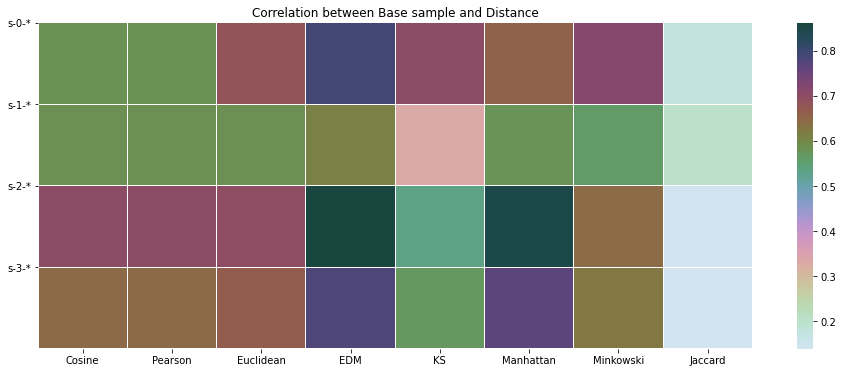

In [324]:
ax = show_heatmap(df_base_set_corr.T)
ticks = ax.set_yticks(range(len(df_base_set_corr.T.index))) # 设置刻度
labels = ax.set_yticklabels(df_base_set_corr.T.index,rotation = 0 ) # 设置刻度标签
ax.set_title("Correlation between Base sample and Distance")

Text(0.5, 1.0, 'Correlation between Base sample and Distance')

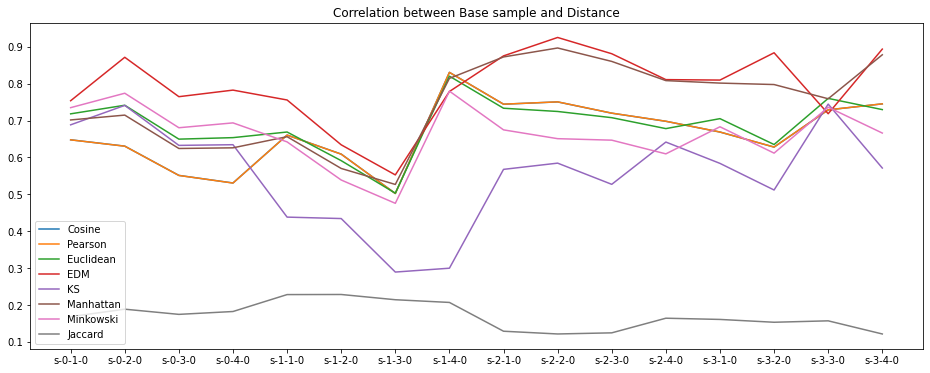

In [325]:
ax = df_train_set_corr.T.plot(kind='line')
ticks = ax.set_xticks(range(len(df_train_set_corr.T.index))) # 设置刻度
labels = ax.set_xticklabels(df_train_set_corr.T.index,rotation = 0 ) # 设置刻度标签
ax.set_title("Correlation between Base sample and Distance")

# Correlations for each train set

In [326]:
df_group = df_all.groupby("train")
df_train_set_corr = pd.DataFrame()
for train_set,df in df_group:    
    df_train_set_corr[train_set] = test.Correlation(df).mean()
print("Total mean correlation")
display(df_train_set_corr.T.mean())
df_train_set_corr.T

Total mean correlation


Cosine      0.66022682
Pearson     0.66022650
Euclidean   0.68637837
EDM         0.79639524
KS          0.55239935
Manhattan   0.74558037
Minkowski   0.66099333
Jaccard     0.17287148
dtype: float64

,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
s-0-1-0,0.64770823,0.64760162,0.71852022,0.75770139,0.73035566,0.70169592,0.73548588,0.16940552
s-0-2-0,0.63061073,0.63046159,0.74204530,0.87284010,0.79878030,0.71527626,0.77487950,0.18665792
s-0-3-0,0.55393034,0.55379548,0.65170733,0.77000853,0.63115379,0.62803222,0.68199813,0.17349828
s-0-4-0,0.53413348,0.53398801,0.65653316,0.79592788,0.70274522,0.63229514,0.69568280,0.18194919
s-1-1-0,0.66537183,0.66529270,0.67310702,0.74394120,0.44790231,0.65613157,0.64801631,0.23312288
s-1-2-0,0.61006136,0.60993655,0.58822158,0.62372874,0.44208337,0.56829509,0.53391963,0.23186354
s-1-3-0,0.49631932,0.49636159,0.49393657,0.55593761,0.26743759,0.52457525,0.46524130,0.21520732
s-1-4-0,0.83011151,0.83007431,0.81291862,0.77785380,0.29168122,0.81387857,0.76758872,0.21243120
s-2-1-0,0.73636480,0.73646712,0.73138950,0.88367553,0.50149288,0.87461727,0.67536049,0.12955681
s-2-2-0,0.73021160,0.73033017,0.71981430,0.92903585,0.56197276,0.89521639,0.65658816,0.12548743


Text(0.5, 1.0, 'Correlation between Train sample and Distance')

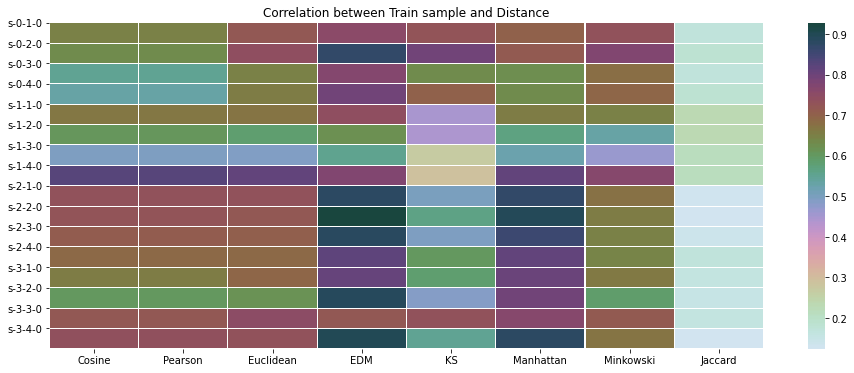

In [327]:
ax = show_heatmap(df_train_set_corr.T)
ticks = ax.set_yticks(range(len(df_train_set_corr.T.index))) # 设置刻度
labels = ax.set_yticklabels(df_train_set_corr.T.index,rotation = 0 ) # 设置刻度标签
ax.set_title("Correlation between Train sample and Distance")

Text(0.5, 1.0, 'Correlation between Train Dataset and Distance')

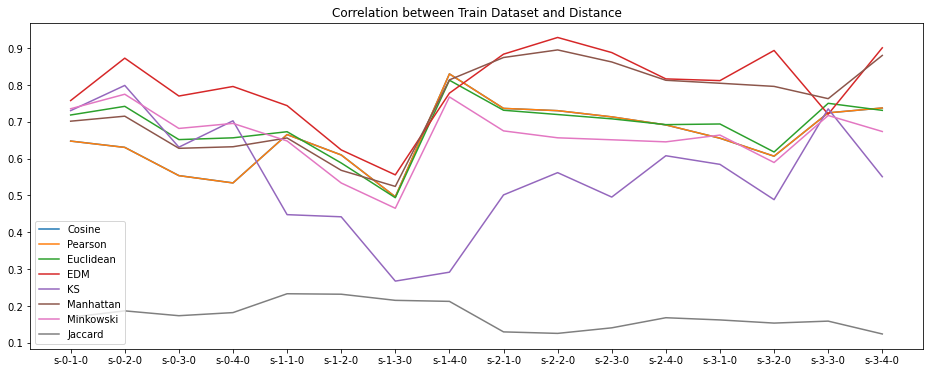

In [328]:
ax = df_train_set_corr.T.plot(kind='line')
ticks = ax.set_xticks(range(len(df_train_set_corr.T.index))) # 设置刻度
labels = ax.set_xticklabels(df_train_set_corr.T.index,rotation = 0 ) # 设置刻度标签
ax.set_title("Correlation between Train Dataset and Distance")

# Detail correlation for each train set

In [329]:
df_group = df_all.groupby("train")
for train_set, df in df_group:
    mask = (df_all.train == train_set)
    df_test = df_all[mask]
    corr = test.Correlation(df_test)
    print("Mean correlation for train set ", train_set)
    display ( corr.mean() )

Mean correlation for train set  s-0-1-0


Cosine      0.64770823
Pearson     0.64760162
Euclidean   0.71852022
EDM         0.75770139
KS          0.73035566
Manhattan   0.70169592
Minkowski   0.73548588
Jaccard     0.16940552
dtype: float64

Mean correlation for train set  s-0-2-0


Cosine      0.63061073
Pearson     0.63046159
Euclidean   0.74204530
EDM         0.87284010
KS          0.79878030
Manhattan   0.71527626
Minkowski   0.77487950
Jaccard     0.18665792
dtype: float64

Mean correlation for train set  s-0-3-0


Cosine      0.55393034
Pearson     0.55379548
Euclidean   0.65170733
EDM         0.77000853
KS          0.63115379
Manhattan   0.62803222
Minkowski   0.68199813
Jaccard     0.17349828
dtype: float64

Mean correlation for train set  s-0-4-0


Cosine      0.53413348
Pearson     0.53398801
Euclidean   0.65653316
EDM         0.79592788
KS          0.70274522
Manhattan   0.63229514
Minkowski   0.69568280
Jaccard     0.18194919
dtype: float64

Mean correlation for train set  s-1-1-0


Cosine      0.66537183
Pearson     0.66529270
Euclidean   0.67310702
EDM         0.74394120
KS          0.44790231
Manhattan   0.65613157
Minkowski   0.64801631
Jaccard     0.23312288
dtype: float64

Mean correlation for train set  s-1-2-0


Cosine      0.61006136
Pearson     0.60993655
Euclidean   0.58822158
EDM         0.62372874
KS          0.44208337
Manhattan   0.56829509
Minkowski   0.53391963
Jaccard     0.23186354
dtype: float64

Mean correlation for train set  s-1-3-0


Cosine      0.49631932
Pearson     0.49636159
Euclidean   0.49393657
EDM         0.55593761
KS          0.26743759
Manhattan   0.52457525
Minkowski   0.46524130
Jaccard     0.21520732
dtype: float64

Mean correlation for train set  s-1-4-0


Cosine      0.83011151
Pearson     0.83007431
Euclidean   0.81291862
EDM         0.77785380
KS          0.29168122
Manhattan   0.81387857
Minkowski   0.76758872
Jaccard     0.21243120
dtype: float64

Mean correlation for train set  s-2-1-0


Cosine      0.73636480
Pearson     0.73646712
Euclidean   0.73138950
EDM         0.88367553
KS          0.50149288
Manhattan   0.87461727
Minkowski   0.67536049
Jaccard     0.12955681
dtype: float64

Mean correlation for train set  s-2-2-0


Cosine      0.73021160
Pearson     0.73033017
Euclidean   0.71981430
EDM         0.92903585
KS          0.56197276
Manhattan   0.89521639
Minkowski   0.65658816
Jaccard     0.12548743
dtype: float64

Mean correlation for train set  s-2-3-0


Cosine      0.71338315
Pearson     0.71349189
Euclidean   0.70807515
EDM         0.88802219
KS          0.49564393
Manhattan   0.86249389
Minkowski   0.65120043
Jaccard     0.14057012
dtype: float64

Mean correlation for train set  s-2-4-0


Cosine      0.69154545
Pearson     0.69163008
Euclidean   0.69232538
EDM         0.81655112
KS          0.60788223
Manhattan   0.81277973
Minkowski   0.64557927
Jaccard     0.16801903
dtype: float64

Mean correlation for train set  s-3-1-0


Cosine      0.65544546
Pearson     0.65550460
Euclidean   0.69409615
EDM         0.81188609
KS          0.58446296
Manhattan   0.80471651
Minkowski   0.66398360
Jaccard     0.16202040
dtype: float64

Mean correlation for train set  s-3-2-0


Cosine      0.60660603
Pearson     0.60672038
Euclidean   0.61801062
EDM         0.89372857
KS          0.48863961
Manhattan   0.79617713
Minkowski   0.58950620
Jaccard     0.15346012
dtype: float64

Mean correlation for train set  s-3-3-0


Cosine      0.72433854
Pearson     0.72437907
Euclidean   0.75026568
EDM         0.72056328
KS          0.73518650
Manhattan   0.76284994
Minkowski   0.71719504
Jaccard     0.15879800
dtype: float64

Mean correlation for train set  s-3-4-0


Cosine      0.73748729
Pearson     0.73758885
Euclidean   0.73108734
EDM         0.90092189
KS          0.55096922
Manhattan   0.88025505
Minkowski   0.67366784
Jaccard     0.12389597
dtype: float64

In [330]:
df_group = df_all.groupby("train")
for train_set, df in df_group:
    mask = (df_all.train == train_set)
    df_test = df_all[mask]
    corr = test.Correlation(df_test)
    print("Detail correlation for train set ", train_set)
    display ( corr )

Detail correlation for train set  s-0-1-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.75388167,0.75393659,0.69819151,0.37640598,0.53960677,0.72153702,0.66124955,0.13182338
accuracy,0.82475579,0.82463079,0.90924658,0.93703881,0.92116961,0.88973109,0.92798854,0.21975415
precision,0.20875300,0.20852276,0.38361711,0.80698849,0.57626279,0.33262789,0.45135673,0.12360561
auc,0.96637339,0.96633722,0.97832063,0.77652413,0.87495407,0.98233442,0.96533623,0.20507656
f1_score,0.48477731,0.48458075,0.62322525,0.89154956,0.73978505,0.58224916,0.67149837,0.16676790


Detail correlation for train set  s-0-2-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.86907313,0.86899846,0.92743845,0.83944377,0.88948554,0.92116367,0.93298386,0.21621512
accuracy,0.74991414,0.74976261,0.86363034,0.96866059,0.91071165,0.83763368,0.89466214,0.21770183
precision,0.19558103,0.19534833,0.37460581,0.80340987,0.56929359,0.32349237,0.44382499,0.12277736
auc,0.93240606,0.93233301,0.97859211,0.86239129,0.91281060,0.97344755,0.97949782,0.21529471
f1_score,0.40607928,0.40586554,0.56595977,0.89029500,0.71160010,0.52064401,0.62342871,0.16130056


Detail correlation for train set  s-0-3-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.82394349,0.82401541,0.73596948,0.37594316,0.46687622,0.75699764,0.68638240,0.13301728
accuracy,0.62334904,0.62316661,0.75855023,0.94973982,0.74571547,0.72802412,0.80220708,0.19747067
precision,0.12602711,0.12579092,0.32245947,0.75837249,0.51385454,0.27195889,0.40101985,0.14599492
auc,0.86231507,0.86220250,0.94281349,0.92675610,0.82083928,0.93043857,0.95883712,0.22017170
f1_score,0.33401697,0.33380197,0.49874399,0.83923109,0.60848346,0.45274190,0.56154419,0.17083683


Detail correlation for train set  s-0-4-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.75085714,0.75085791,0.76004570,0.54727539,0.62562667,0.77217664,0.74659142,0.15656081
accuracy,0.66006387,0.65989426,0.79459480,0.94362131,0.82314808,0.76895841,0.83634926,0.20534361
precision,0.09745676,0.09722273,0.29905274,0.73947716,0.53428396,0.24700791,0.38035067,0.15070789
auc,0.82644597,0.82633597,0.91497670,0.90103417,0.85862899,0.90445170,0.93399451,0.21614893
f1_score,0.33584365,0.33562919,0.51399586,0.84823136,0.67203841,0.46888107,0.58112812,0.18098473


Detail correlation for train set  s-1-1-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.78423509,0.78443222,0.69465677,0.76283763,0.15534432,0.85855232,0.61833942,0.09268468
accuracy,0.65549349,0.65526529,0.70923578,0.77309305,0.57297428,0.59687761,0.70572447,0.28999943
precision,0.69655967,0.69635325,0.73493557,0.75495665,0.51223952,0.63831617,0.72310403,0.25787586
auc,0.43860930,0.43860360,0.46074087,0.64657438,0.54846215,0.47473115,0.45297632,0.29527413
f1_score,0.75196159,0.75180915,0.76596611,0.78224427,0.45049130,0.71218063,0.73993729,0.22978028


Detail correlation for train set  s-1-2-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.87701811,0.87721592,0.79226038,0.78506196,0.19864360,0.93316816,0.69099453,0.10403666
accuracy,0.60538115,0.60507776,0.63783759,0.75863473,0.60757754,0.52265715,0.61607677,0.30273339
precision,0.67175231,0.67148808,0.68542190,0.75416355,0.53184390,0.59527386,0.64894856,0.26532299
auc,0.17373820,0.17370866,0.10554107,0.05682750,0.39584872,0.13363213,0.04207683,0.24886928
f1_score,0.72241705,0.72219231,0.72004694,0.76395597,0.47650308,0.65674415,0.67150147,0.23835539


Detail correlation for train set  s-1-3-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.72628105,0.72647749,0.66503534,0.80245721,0.22321536,0.79739780,0.58823396,0.13707557
accuracy,0.31350719,0.31354425,0.34510807,0.40801852,0.34105836,0.35143573,0.34993296,0.30509459
precision,0.61059554,0.61045295,0.61920580,0.57322435,0.22269936,0.56866426,0.59236758,0.20946951
auc,0.01970894,0.01985672,0.04780025,0.17542761,0.25645321,0.09191704,0.05976358,0.18958248
f1_score,0.81150386,0.81147654,0.79253341,0.82056036,0.29376168,0.81346145,0.73590843,0.23481446


Detail correlation for train set  s-1-4-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.78860896,0.78878907,0.69946663,0.86839438,0.25163850,0.86656184,0.60347273,0.05100076
accuracy,0.88034240,0.88025016,0.87821510,0.79790305,0.31214387,0.84062665,0.84088971,0.24426068
precision,0.77455059,0.77440089,0.78711351,0.67143680,0.25642111,0.71208392,0.76371283,0.22673400
auc,0.88620313,0.88618294,0.88509034,0.79349006,0.36388340,0.86901030,0.85556388,0.33982743
f1_score,0.82085247,0.82074849,0.81470753,0.75804473,0.27431922,0.78111013,0.77430447,0.20033314


Detail correlation for train set  s-2-1-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.72072818,0.72087140,0.69941585,0.93293704,0.44672694,0.91064736,0.62914956,0.09786067
accuracy,0.83273547,0.83278884,0.83392110,0.85643821,0.59790167,0.89779180,0.78171560,0.15489288
precision,0.53206816,0.53219704,0.54176062,0.80331278,0.38198711,0.73661740,0.50571070,0.12753329
auc,0.93056195,0.93060496,0.92528810,0.91262713,0.64604221,0.95566477,0.86231462,0.15346303
f1_score,0.66573026,0.66587335,0.65656180,0.91306247,0.43480651,0.87236504,0.59791200,0.11403416


Detail correlation for train set  s-2-2-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.78944174,0.78956361,0.77360848,0.96938035,0.58549580,0.94860540,0.70339569,0.11425763
accuracy,0.89017676,0.89022234,0.87069950,0.87189015,0.66858802,0.91727816,0.80548928,0.14646767
precision,0.46660168,0.46676752,0.46913673,0.85585212,0.39652825,0.73955351,0.42013805,0.10999254
auc,0.80820609,0.80832267,0.79802803,0.98070149,0.61899429,0.96396340,0.73081555,0.13572152
f1_score,0.69663174,0.69677473,0.68759877,0.96735515,0.54025743,0.90668150,0.62310225,0.12099781


Detail correlation for train set  s-2-3-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.69318204,0.69333548,0.67263358,0.93175259,0.43907681,0.89714615,0.60312874,0.10234617
accuracy,0.79840940,0.79848854,0.79997196,0.89862852,0.58569151,0.90622943,0.74359415,0.16268918
precision,0.49804757,0.49816831,0.50974470,0.77646904,0.36234275,0.69654195,0.47625720,0.14728459
auc,0.93291782,0.93296002,0.92162240,0.91862930,0.66023646,0.95198809,0.85451110,0.16385473
f1_score,0.64435891,0.64450710,0.63640314,0.91463151,0.43087213,0.86056384,0.57851095,0.12667595


Detail correlation for train set  s-2-4-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.77270290,0.77281388,0.76378723,0.92965415,0.62904106,0.92379323,0.70206041,0.13299874
accuracy,0.82860575,0.82859070,0.82697176,0.67184972,0.74437718,0.77055752,0.78783244,0.20696785
precision,0.32044852,0.32059703,0.33897145,0.70739453,0.35503056,0.58824079,0.31095372,0.15291715
auc,0.87736669,0.87741032,0.87222021,0.85099712,0.74662418,0.91079533,0.82095027,0.19451553
f1_score,0.65860337,0.65873848,0.65967626,0.92286006,0.56433815,0.87051177,0.60609951,0.15269591


Detail correlation for train set  s-3-1-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.71652040,0.71659687,0.74800405,0.94404785,0.59526573,0.91097516,0.70147554,0.13188314
accuracy,0.85113587,0.85113747,0.86594496,0.64353110,0.70791757,0.81113426,0.83031147,0.20594690
precision,0.25431896,0.25440862,0.32751133,0.69799040,0.35404049,0.53167958,0.33317220,0.14098343
auc,0.85071957,0.85076111,0.87685238,0.85254148,0.71727847,0.92806731,0.83402787,0.18666551
f1_score,0.60453252,0.60461894,0.65216803,0.92131964,0.54781256,0.84172622,0.62093095,0.14462303


Detail correlation for train set  s-3-2-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.60298396,0.60312005,0.60826561,0.93828426,0.42647150,0.82103532,0.57684314,0.10005147
accuracy,0.61564617,0.61573181,0.63367126,0.83840184,0.57176127,0.77276823,0.60651918,0.21704553
precision,0.42131733,0.42145704,0.43844435,0.82961237,0.35802334,0.66232554,0.42098861,0.13596633
auc,0.84788442,0.84795521,0.85477766,0.94972575,0.67829607,0.94828870,0.81476835,0.19943180
f1_score,0.54519828,0.54533780,0.55489422,0.91261862,0.40864589,0.77646785,0.52841171,0.11480549


Detail correlation for train set  s-3-3-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.82451020,0.82454261,0.85189842,0.77940536,0.82837643,0.84209615,0.81535031,0.17039228
accuracy,0.73571546,0.73565668,0.75760023,0.46665995,0.75052179,0.59672996,0.72990638,0.15152559
precision,0.45307646,0.45321498,0.47418625,0.75594104,0.46200887,0.68013567,0.44467809,0.11879116
auc,0.79374868,0.79378466,0.82602405,0.76455089,0.82183786,0.82120209,0.79406165,0.17834778
f1_score,0.81464188,0.81469641,0.84161948,0.83625917,0.81318753,0.87408583,0.80197875,0.17493319


Detail correlation for train set  s-3-4-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.70654246,0.70668201,0.68948286,0.95399342,0.50943261,0.90467573,0.62165146,0.09411427
accuracy,0.84311846,0.84318243,0.83801832,0.89611040,0.65330989,0.92600139,0.77833777,0.14531305
precision,0.53838253,0.53851007,0.54779183,0.81856236,0.39111875,0.74427850,0.51302467,0.12682687
auc,0.93718944,0.93722753,0.92482319,0.90595187,0.72213464,0.95490314,0.85627020,0.14149537
f1_score,0.66220355,0.66234219,0.65532050,0.92999139,0.47885021,0.87141652,0.59905509,0.11173029
